In [1]:
# Import necessary dependencies
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers

# I. Read in Data

Other features to add:

1) Normalize by year (already there)

2) Round of game (data)

3) Ratings (bball_ref)

4) Poll stats (bball_ref)

* Conference
* Round of game
* Normalize stats by years
* Ratings
* Polling stats
* Distance from game location
* Conference standings
* Conference tourney results
* Result if played during reg. season
* Winning streak going into tournament
* Coach stats

## Utils
Only look at these methods if you really care to.

In [2]:
def create_key_from_fields(*a):
    first = True
    key = ''
    for i in a:
        if first is True:
            key = i.astype(str)
            first = False
        else:
            key = key + '_' + i.astype(str)
    return key

def get_nan_column_list(df):
    return df.columns[df.isna().any()].tolist()
    
def parse_single_season_team_data(dataframe, year):
    dataframe['Year'] = year + 1
    dataframe.rename(
        index=str,
        columns={
            'W.1': 'Conf. wins', 'L.1': 'Conf. losses',
            'W.2': 'Home wins', 'L.2': 'Home losses',
            'W.3': 'Away wins', 'L.3': 'Away losses',
            'Tm.': 'Points for', 'Opp.': 'Points against'
        },
        inplace=True
    )
    # Drop columns that have known null values for multiple rows
    dataframe.drop(labels=['Conf. wins', 'Conf. losses', 'MP', 'ORB', 'Rk', 'Unnamed: 16',
                           
                          'Home wins', 'Home losses', 'Away wins', 'Away losses',
                           'Points against', 'TRB', 'TOV', 'PF'
                           
                          ], inplace=True, axis=1)
    
    # Experiment w/ columns to drop
#     dataframe.drop(labels=['G', 'W', 'L', 'Points for', 'FG', 'FGA', '3P', '3PA', 'FT', 'FTA'], inplace=True, axis=1)

    return dataframe

def load_season_team_data(start, end):
    bball_ref_dir = base_dir + '/data/bball_reference/'
    df_regular_season_aggregated = pd.DataFrame()
    for year in range(start, end):
        regular_season_csv = bball_ref_dir + str(year) + '_season.csv'
        df_regular_season = pd.read_csv(regular_season_csv, header=1)
        df_regular_season = parse_single_season_team_data(df_regular_season, year)
        df_regular_season_aggregated = df_regular_season_aggregated.append(df_regular_season)
    return df_regular_season_aggregated

Define constants for filepaths to be used later in notebook

In [3]:
# Define Constants
base_dir = '/Users/kluteytk/development/projects/march_madness'
tourney_results_csv = base_dir + '/data/DataFiles/NCAATourneyCompactResults.csv'
tourney_seeds_csv = base_dir + '/data/DataFiles/NCAATourneySeeds.csv'
tourney_rounds_csv = base_dir + '/data/DataFiles/NCAATourneySeedRoundSlots.csv'
teams_csv = base_dir + '/data/DataFiles/Teams.csv'

## Team Data
### Single Season Stats

In [4]:
df_regular_season_aggregated = load_season_team_data(1993, 2017)

df_regular_season_aggregated.keys()

Index(['School', 'G', 'W', 'L', 'W-L%', 'SRS', 'SOS', 'Points for', 'FG',
       'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'AST', 'STL',
       'BLK', 'Year'],
      dtype='object')

In [5]:
nan_cols = get_nan_column_list(df_regular_season_aggregated)
print(nan_cols)

[]


In [6]:
df_regular_season_aggregated.head()

,School,G,W,L,W-L%,SRS,SOS,Points for,FG,FGA,...,3P,3PA,3P%,FT,FTA,FT%,AST,STL,BLK,Year
0,Air Force,28,9,19,0.321,-7.45,2.05,1833,644,1554,...,136,434,0.313,409,584,0.700,285,178,109,1994
1,Akron,26,8,18,0.308,-10.69,-5.07,1614,580,1327,...,134,368,0.364,320,493,0.649,316,163,47,1994
2,Alabama-Birmingham,35,21,14,0.600,10.82,5.68,2432,888,1998,...,200,539,0.371,456,650,0.702,501,246,135,1994
3,Alabama State,27,14,13,0.519,-8.48,-9.70,2378,852,1772,...,133,359,0.370,541,767,0.705,393,194,42,1994
4,Alabama,29,16,13,0.552,9.66,7.83,2192,782,1691,...,170,505,0.337,458,702,0.652,337,185,120,1994


In [7]:
df_regular_season_aggregated.shape

(7793, 21)

### Metadata/Name Data

In [8]:
df_team_metadata = pd.read_csv(teams_csv)
df_team_metadata.drop(labels=['FirstD1Season', 'LastD1Season'], inplace=True, axis=1)

df_team_metadata.head()

,TeamID,TeamName
0,1101,Abilene Christian
1,1102,Air Force
2,1103,Akron
3,1104,Alabama
4,1105,Alabama A&M


### Seed Data

In [9]:
# df_seeds = pd.read_csv(tourney_seeds_csv)
# df_seeds.head()

In [10]:
# df_seeds = pd.read_csv(tourney_seeds_csv)
# df_seeds = parse_seed(df_seeds)
# df_seeds['TeamSeasonId'] = create_key_from_fields(df_seeds['TeamID'], df_seeds['Season'])
# df_seeds = df_seeds.drop(['TeamID', 'Season'], axis=1)

# df_seeds.head()

### Merge Team Data

In [11]:
df_regular_season_data = pd.merge(left=df_team_metadata, right=df_regular_season_aggregated, how='inner', right_on='School', left_on='TeamName').drop('School', axis=1)

df_map = pd.merge(left=df_team_metadata, right=df_regular_season_aggregated, how='left', right_on='School', left_on='TeamName').drop('School', axis=1)

df_regular_season_data['TeamSeasonId'] = create_key_from_fields(df_regular_season_data['TeamID'], df_regular_season_data['Year'])

df_regular_season_data.shape

(5426, 23)

In [12]:
df_regular_season_data.head()

,TeamID,TeamName,G,W,L,W-L%,SRS,SOS,Points for,FG,...,3PA,3P%,FT,FTA,FT%,AST,STL,BLK,Year,TeamSeasonId
0,1101,Abilene Christian,31,11,20,0.355,-19.60,-4.12,2214,737,...,599,0.402,499,666,0.749,402,221,72,2015,1101_2015
1,1101,Abilene Christian,31,10,21,0.323,-17.20,-6.34,1976,695,...,610,0.380,354,487,0.727,394,203,38,2016,1101_2016
2,1101,Abilene Christian,31,13,18,0.419,-13.93,-7.53,2209,771,...,570,0.367,458,653,0.701,422,233,78,2017,1101_2017
3,1102,Air Force,28,9,19,0.321,-7.45,2.05,1833,644,...,434,0.313,409,584,0.700,285,178,109,1994,1102_1994
4,1102,Air Force,26,8,18,0.308,-6.27,2.41,1813,613,...,420,0.338,445,630,0.706,281,168,111,1995,1102_1995


#### Seed Metadata

In [13]:
# df_regular_season_data = pd.merge(left=df_seeds, right=df_regular_season_data, how='inner', on='TeamSeasonId')

# df_regular_season_data.shape

In [14]:
# df_regular_season_data['WLSOS'] = df_regular_season_data['W-L%'] * df_regular_season_data['SOS']
# df_regular_season_data = df_regular_season_data.drop(['W-L%', 'SOS'], axis=1)

In [15]:
df_regular_season_data.head()

,TeamID,TeamName,G,W,L,W-L%,SRS,SOS,Points for,FG,...,3PA,3P%,FT,FTA,FT%,AST,STL,BLK,Year,TeamSeasonId
0,1101,Abilene Christian,31,11,20,0.355,-19.60,-4.12,2214,737,...,599,0.402,499,666,0.749,402,221,72,2015,1101_2015
1,1101,Abilene Christian,31,10,21,0.323,-17.20,-6.34,1976,695,...,610,0.380,354,487,0.727,394,203,38,2016,1101_2016
2,1101,Abilene Christian,31,13,18,0.419,-13.93,-7.53,2209,771,...,570,0.367,458,653,0.701,422,233,78,2017,1101_2017
3,1102,Air Force,28,9,19,0.321,-7.45,2.05,1833,644,...,434,0.313,409,584,0.700,285,178,109,1994,1102_1994
4,1102,Air Force,26,8,18,0.308,-6.27,2.41,1813,613,...,420,0.338,445,630,0.706,281,168,111,1995,1102_1995


## Game Data
### Tourney Results

In [16]:
# Read from CSV
df_game_results = pd.read_csv(tourney_results_csv)
df_game_results.drop(labels=['WLoc', 'NumOT'], inplace=True, axis=1)

# Create unique keys
df_game_results['GameID'] = create_key_from_fields(df_game_results['Season'], df_game_results['WTeamID'], df_game_results['LTeamID'])
df_game_results['TeamA_ID'] = create_key_from_fields(df_game_results['WTeamID'], df_game_results['Season'])
df_game_results['TeamB_ID'] = create_key_from_fields(df_game_results['LTeamID'], df_game_results['Season'])
df_game_results.drop(labels=['WTeamID', 'LTeamID'], inplace=True, axis=1)

# Create difference in score
df_game_results['ScoreDiff'] = df_game_results.WScore - df_game_results.LScore
df_game_results.drop(labels=['WScore', 'LScore'], inplace=True, axis=1)

df_game_results.head()

,Season,DayNum,GameID,TeamA_ID,TeamB_ID,ScoreDiff
0,1985,136,1985_1116_1234,1116_1985,1234_1985,9
1,1985,136,1985_1120_1345,1120_1985,1345_1985,1
2,1985,136,1985_1207_1250,1207_1985,1250_1985,25
3,1985,136,1985_1229_1425,1229_1985,1425_1985,3
4,1985,136,1985_1242_1325,1242_1985,1325_1985,11


In [17]:
df_game_results.shape

(2117, 6)

### Tourney Rounds/Seeds

In [18]:
df_rounds = pd.read_csv(tourney_rounds_csv)
df_rounds.head()

,Seed,GameRound,GameSlot,EarlyDayNum,LateDayNum
0,W01,1,R1W1,136,137
1,W01,2,R2W1,138,139
2,W01,3,R3W1,143,144
3,W01,4,R4W1,145,146
4,W01,5,R5WX,152,152


In [19]:
df_seeds = pd.read_csv(tourney_seeds_csv)
# df_seeds = parse_seed(df_seeds)
df_seeds['TeamSeasonId'] = create_key_from_fields(df_seeds['TeamID'], df_seeds['Season'])
df_seeds = df_seeds.drop(['TeamID', 'Season'], axis=1)

df_seeds.head()

,Seed,TeamSeasonId
0,W01,1207_1985
1,W02,1210_1985
2,W03,1228_1985
3,W04,1260_1985
4,W05,1374_1985


In [20]:
df_game_results = pd.merge(left=df_game_results, right=df_seeds, how='inner', left_on=['TeamA_ID'], right_on=['TeamSeasonId'])
df_game_results.drop(labels=['TeamSeasonId'], inplace=True, axis=1)

df_game_results = pd.merge(left=df_game_results, right=df_seeds, how='inner', left_on=['TeamB_ID'], right_on=['TeamSeasonId'])
df_game_results.drop(labels=['TeamSeasonId'], inplace=True, axis=1)


df_game_results.head()

,Season,DayNum,GameID,TeamA_ID,TeamB_ID,ScoreDiff,Seed_x,Seed_y
0,1985,136,1985_1116_1234,1116_1985,1234_1985,9,X09,X08
1,1985,136,1985_1120_1345,1120_1985,1345_1985,1,Z11,Z06
2,1985,138,1985_1120_1242,1120_1985,1242_1985,2,Z11,Z03
3,1985,136,1985_1207_1250,1207_1985,1250_1985,25,W01,W16
4,1985,138,1985_1207_1396,1207_1985,1396_1985,17,W01,W08


In [21]:
df_a = pd.merge(left=df_game_results, right=df_rounds, how='inner', left_on=['DayNum', 'Seed_x'], right_on=['EarlyDayNum', 'Seed'])
df_a.drop(labels=['GameSlot', 'EarlyDayNum', 'LateDayNum', 'Seed', 'DayNum'], inplace=True, axis=1)

df_b = pd.merge(left=df_game_results, right=df_rounds, how='inner', left_on=['DayNum', 'Seed_x'], right_on=['LateDayNum', 'Seed'])
df_b.drop(labels=['GameSlot', 'EarlyDayNum', 'LateDayNum', 'Seed', 'DayNum'], inplace=True, axis=1)

df_c = df_a[~df_a["GameID"].isin(df_b["GameID"])].copy()

df_game_results = pd.concat([df_b, df_c], sort=False)

df_game_results.shape

(2117, 8)

In [22]:
df_game_results.head()

,Season,GameID,TeamA_ID,TeamB_ID,ScoreDiff,Seed_x,Seed_y,GameRound
0,1985,1985_1207_1385,1207_1985,1385_1985,18,W01,X01,5
1,1986,1986_1181_1242,1181_1986,1242_1986,4,W01,X01,5
2,1992,1992_1181_1231,1181_1992,1231_1992,3,W01,X02,5
3,1993,1993_1314_1242,1314_1993,1242_1993,10,W01,X02,5
4,1999,1999_1181_1277,1181_1999,1277_1999,6,W01,X01,5


In [23]:
def parse_seed(df_seeds, orig_label, dest_label):
    df_seeds[orig_label] = df_seeds[orig_label].str[1:3]
    df_seeds[dest_label] = df_seeds[orig_label].apply(pd.to_numeric)
    df_seeds.drop(labels=[orig_label], inplace=True, axis=1)
    return df_seeds

df_game_results = parse_seed(df_game_results, 'Seed_x', 'Seed_int_x')
df_game_results = parse_seed(df_game_results, 'Seed_y', 'Seed_int_y')
df_game_results.head()

,Season,GameID,TeamA_ID,TeamB_ID,ScoreDiff,GameRound,Seed_int_x,Seed_int_y
0,1985,1985_1207_1385,1207_1985,1385_1985,18,5,1,1
1,1986,1986_1181_1242,1181_1986,1242_1986,4,5,1,1
2,1992,1992_1181_1231,1181_1992,1231_1992,3,5,1,2
3,1993,1993_1314_1242,1314_1993,1242_1993,10,5,1,2
4,1999,1999_1181_1277,1181_1999,1277_1999,6,5,1,1


In [24]:
# Create mirror of score
df_mirror = pd.DataFrame()
for col, series in df_game_results.iteritems():
    if col == 'ScoreDiff':
        df_mirror[col] = -series
    else:
        df_mirror[col] = series

df_mirror.head()

,Season,GameID,TeamA_ID,TeamB_ID,ScoreDiff,GameRound,Seed_int_x,Seed_int_y
0,1985,1985_1207_1385,1207_1985,1385_1985,-18,5,1,1
1,1986,1986_1181_1242,1181_1986,1242_1986,-4,5,1,1
2,1992,1992_1181_1231,1181_1992,1231_1992,-3,5,1,2
3,1993,1993_1314_1242,1314_1993,1242_1993,-10,5,1,2
4,1999,1999_1181_1277,1181_1999,1277_1999,-6,5,1,1


In [25]:
# Make keys unique
df_game_results['GameID'] = df_game_results['GameID'] + '_a'
df_mirror['GameID'] = df_mirror['GameID'] + '_b'

df_game_results = df_game_results.append(df_mirror, sort=False)

df_game_results.head()


,Season,GameID,TeamA_ID,TeamB_ID,ScoreDiff,GameRound,Seed_int_x,Seed_int_y
0,1985,1985_1207_1385_a,1207_1985,1385_1985,18,5,1,1
1,1986,1986_1181_1242_a,1181_1986,1242_1986,4,5,1,1
2,1992,1992_1181_1231_a,1181_1992,1231_1992,3,5,1,2
3,1993,1993_1314_1242_a,1314_1993,1242_1993,10,5,1,2
4,1999,1999_1181_1277_a,1181_1999,1277_1999,6,5,1,1


## c. Merge features and labels

In [26]:
df_team_a = pd.merge(left=df_game_results, right=df_regular_season_data, how='inner', left_on=['TeamA_ID'], right_on=['TeamSeasonId'])
df_team_a.drop(labels=['TeamSeasonId', 'Year'], inplace=True, axis=1)

df_team_b = pd.merge(left=df_game_results, right=df_regular_season_data, how='inner', left_on=['TeamB_ID'], right_on=['TeamSeasonId'])
df_team_b.drop(labels=['TeamSeasonId', 'Year', 'Season', 'ScoreDiff', 'TeamA_ID', 'TeamB_ID', 'Seed_int_x', 'Seed_int_y', 'GameRound'], inplace=True, axis=1)

df_dataset = pd.merge(left=df_team_a, right=df_team_b, how='inner', on='GameID')

df_dataset.shape

(436, 50)

In [27]:
df_dataset.head()

,Season,GameID,TeamA_ID,TeamB_ID,ScoreDiff,GameRound,Seed_int_x,Seed_int_y,TeamID_x,TeamName_x,...,FG%_y,3P_y,3PA_y,3P%_y,FT_y,FTA_y,FT%_y,AST_y,STL_y,BLK_y
0,2017,2017_1246_1417_a,1246_2017,1417_2017,11,3,2,3,1246,Kentucky,...,0.454,200,551,0.363,450,651,0.691,502,175,110
1,2017,2017_1246_1297_a,1246_2017,1297_2017,9,1,2,15,1246,Kentucky,...,0.439,234,656,0.357,372,545,0.683,439,142,88
2,2017,2017_1246_1455_a,1246_2017,1455_2017,3,2,2,10,1246,Kentucky,...,0.429,250,771,0.324,551,768,0.717,489,255,125
3,2017,2017_1246_1417_b,1246_2017,1417_2017,-11,3,2,3,1246,Kentucky,...,0.454,200,551,0.363,450,651,0.691,502,175,110
4,2017,2017_1246_1297_b,1246_2017,1297_2017,-9,1,2,15,1246,Kentucky,...,0.439,234,656,0.357,372,545,0.683,439,142,88


In [28]:
df_dataset.keys()

Index(['Season', 'GameID', 'TeamA_ID', 'TeamB_ID', 'ScoreDiff', 'GameRound',
       'Seed_int_x', 'Seed_int_y', 'TeamID_x', 'TeamName_x', 'G_x', 'W_x',
       'L_x', 'W-L%_x', 'SRS_x', 'SOS_x', 'Points for_x', 'FG_x', 'FGA_x',
       'FG%_x', '3P_x', '3PA_x', '3P%_x', 'FT_x', 'FTA_x', 'FT%_x', 'AST_x',
       'STL_x', 'BLK_x', 'TeamID_y', 'TeamName_y', 'G_y', 'W_y', 'L_y',
       'W-L%_y', 'SRS_y', 'SOS_y', 'Points for_y', 'FG_y', 'FGA_y', 'FG%_y',
       '3P_y', '3PA_y', '3P%_y', 'FT_y', 'FTA_y', 'FT%_y', 'AST_y', 'STL_y',
       'BLK_y'],
      dtype='object')

### Split training and test data

In [29]:
train_dataset = df_dataset.sample(frac=0.8,random_state=0)
test_dataset = df_dataset.drop(train_dataset.index)

train_labels = train_dataset.pop('ScoreDiff')
test_labels = test_dataset.pop('ScoreDiff')

test_dataset.shape

(87, 49)

# II. Groom & Normalize Features

### Utils

In [30]:
def groom_to_features(df):
    df = df.drop(
    labels=['Season', 'TeamA_ID', 'TeamB_ID',
            'GameID', 'TeamID_x', 'TeamName_x',
           'TeamID_y', 'TeamName_y'],
    axis=1)
    return df

def norm(x, train_stats):
    return (x - train_stats['mean']) / train_stats['std']

def denorm(x, train_stats):
    return (x * train_stats['std']) + train_stats['mean']

## Groom
Remove identifying & non-scalar columns.

In [31]:
df_final_training_dataset = groom_to_features(train_dataset)
df_final_training_dataset.head()

,GameRound,Seed_int_x,Seed_int_y,G_x,W_x,L_x,W-L%_x,SRS_x,SOS_x,Points for_x,...,FG%_y,3P_y,3PA_y,3P%_y,FT_y,FTA_y,FT%_y,AST_y,STL_y,BLK_y
153,2,3,6,32,15,17,0.469,10.48,9.69,2480,...,0.430,252,725,0.348,464,658,0.705,508,257,192
393,2,6,3,30,17,13,0.567,10.63,7.53,2104,...,0.430,129,388,0.332,288,402,0.716,353,169,130
54,1,1,16,40,33,7,0.825,23.44,10.69,3311,...,0.458,222,657,0.338,485,769,0.631,469,146,101
188,1,10,7,35,26,9,0.743,17.39,4.24,2535,...,0.455,221,643,0.344,500,749,0.668,480,196,145
196,1,12,5,33,22,11,0.667,1.00,-3.71,2580,...,0.450,194,589,0.329,564,794,0.710,489,254,91


## Describe
Evaluate distributions of feature variables

In [32]:
train_stats = df_final_training_dataset.describe()
train_stats = train_stats.transpose()
train_stats.head()

,count,mean,std,min,25%,50%,75%,max
GameRound,349.0,1.412607,1.048514,0.0,1.0,1.0,2.0,6.0
Seed_int_x,349.0,6.644699,4.470832,1.0,3.0,6.0,10.0,16.0
Seed_int_y,349.0,10.017192,4.312471,1.0,7.0,11.0,14.0,16.0
G_x,349.0,33.051576,3.045192,27.0,31.0,33.0,35.0,40.0
W_x,349.0,20.392550,5.307017,8.0,17.0,20.0,23.0,35.0


## Normalize

In [33]:
normed_train_data = norm(df_final_training_dataset, train_stats)

normed_train_data.head()

,GameRound,Seed_int_x,Seed_int_y,G_x,W_x,L_x,W-L%_x,SRS_x,SOS_x,Points for_x,...,FG%_y,3P_y,3PA_y,3P%_y,FT_y,FTA_y,FT%_y,AST_y,STL_y,BLK_y
153,0.560215,-0.815217,-0.931529,-0.345323,-1.016117,1.277147,-1.212589,0.031056,0.920364,0.122404,...,-0.690733,0.992933,1.200381,-0.016585,-0.185906,-0.276880,0.265697,0.932390,1.010331,1.881724
393,0.560215,-0.144201,-1.627186,-1.002096,-0.639257,0.100317,-0.374108,0.051300,0.452666,-1.042888,...,-0.690733,-1.499823,-1.589691,-0.577866,-2.268926,-2.581692,0.577627,-1.202627,-1.007047,0.331142
54,-0.393517,-1.262561,1.387327,2.281769,2.375619,-1.664928,1.833324,1.780128,1.136892,2.697823,...,0.522613,0.384944,0.637399,-0.367385,0.062636,0.722472,-1.832741,0.395192,-1.534316,-0.394131
188,-0.393517,0.750487,-0.699643,0.639836,1.056611,-1.076513,1.131737,0.963624,-0.259708,0.292859,...,0.392611,0.364677,0.521491,-0.156905,0.240166,0.542409,-0.783522,0.546709,-0.388078,0.706282
196,-0.393517,1.197831,-1.163415,-0.016937,0.302891,-0.488098,0.481486,-1.248357,-1.981099,0.432322,...,0.175943,-0.182513,0.074417,-0.683106,0.997628,0.947552,0.407483,0.670678,0.941557,-0.644225


In [34]:
normed_train_labels = norm(train_labels, train_labels.describe().transpose())
normed_train_labels.head()

153   -0.984865
393   -0.356352
54     3.021903
188    0.429289
196   -0.199224
Name: ScoreDiff, dtype: float64

# III. Visualizations

/anaconda3/envs/march_madness/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


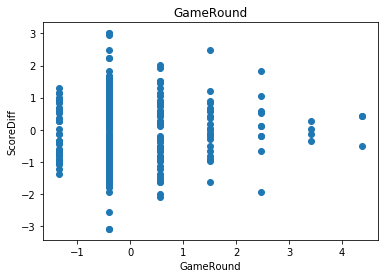

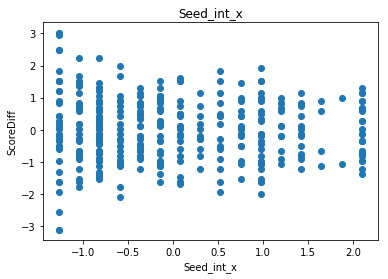

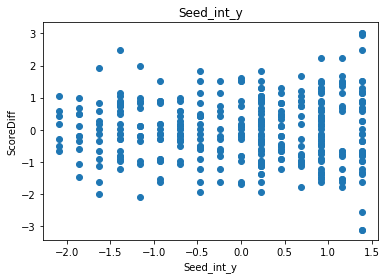

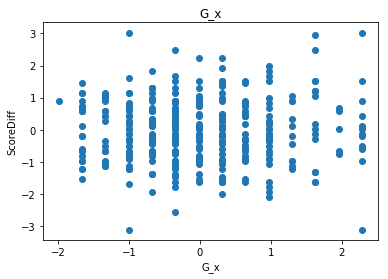

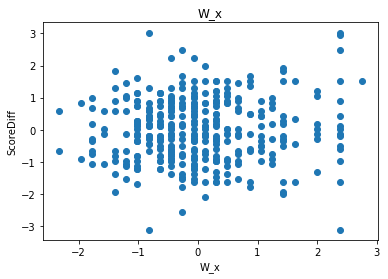

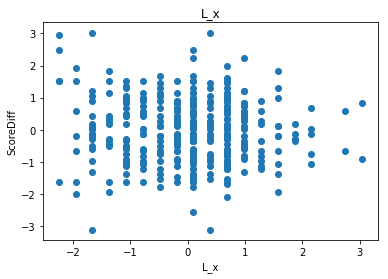

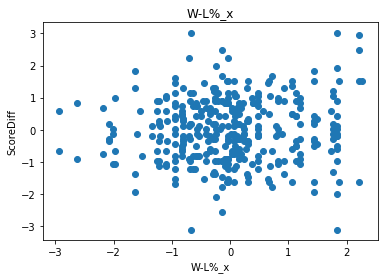

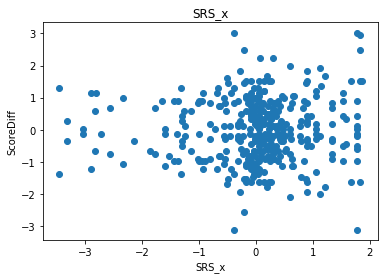

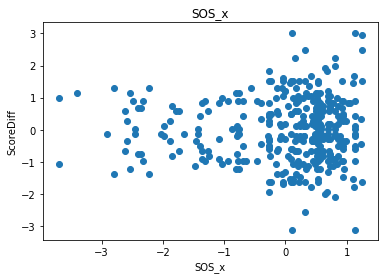

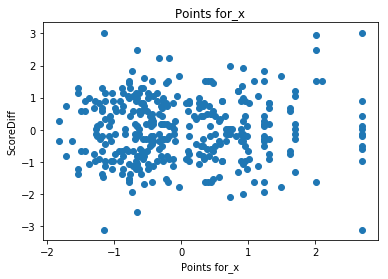

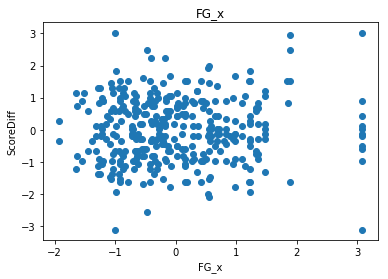

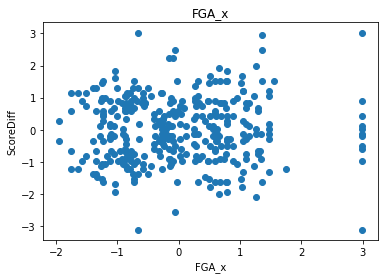

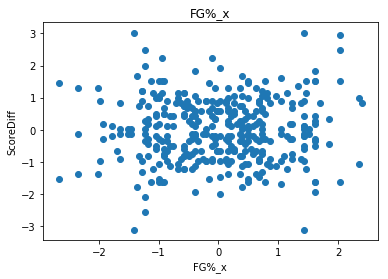

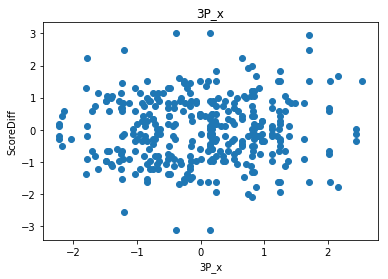

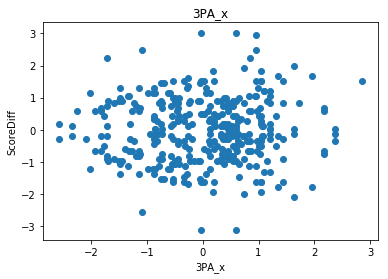

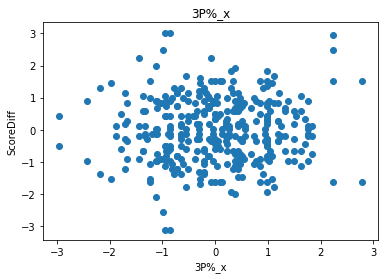

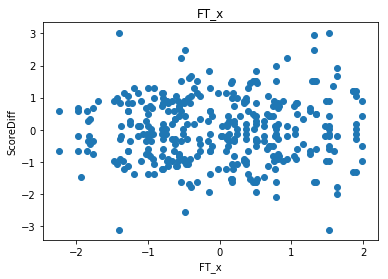

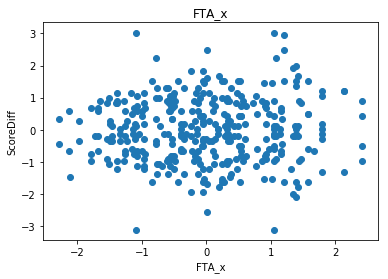

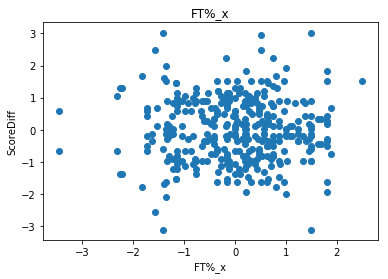

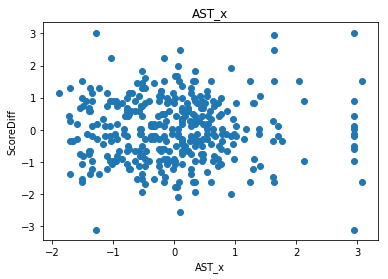

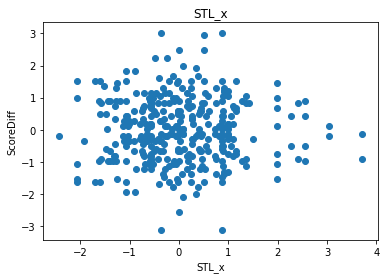

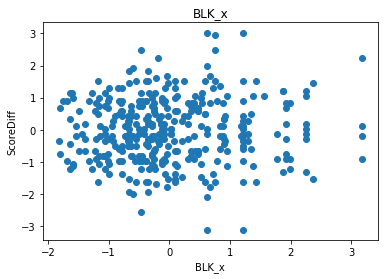

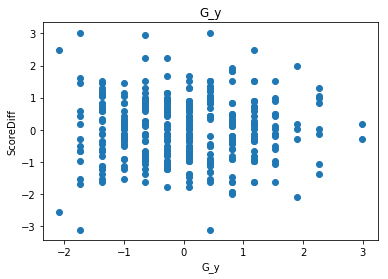

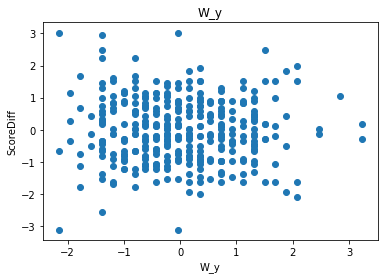

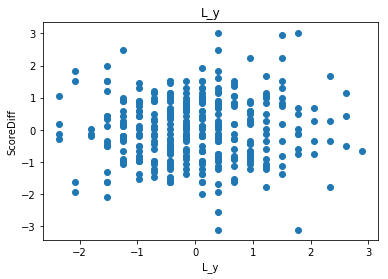

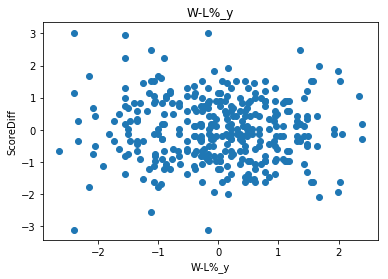

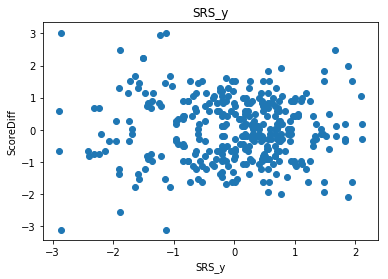

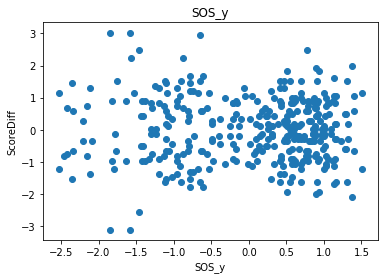

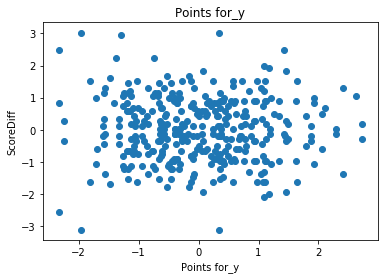

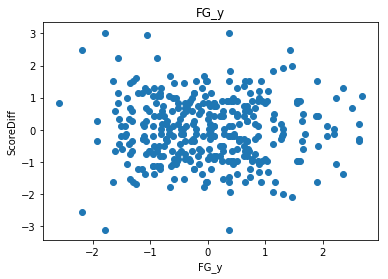

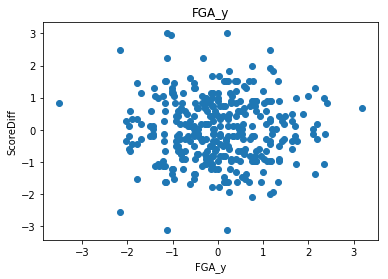

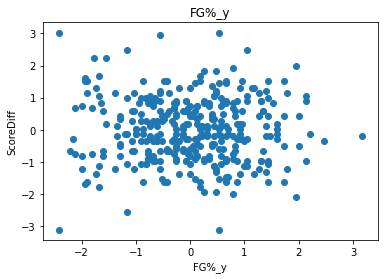

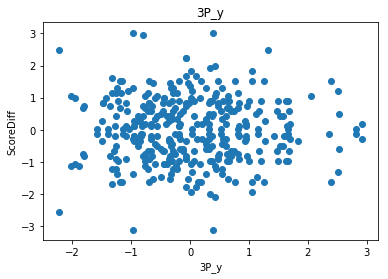

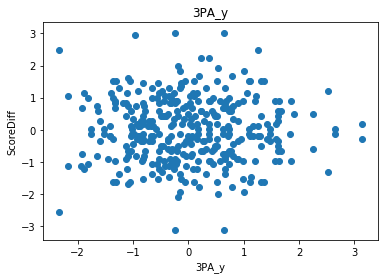

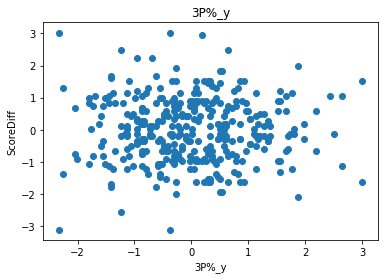

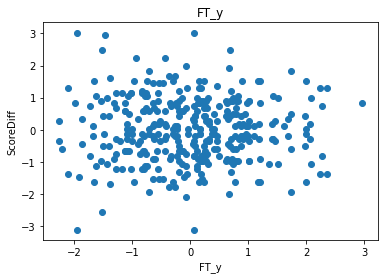

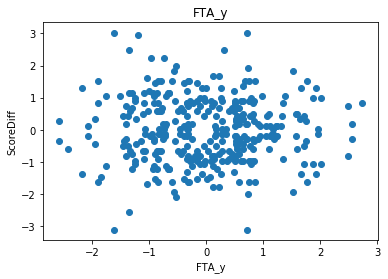

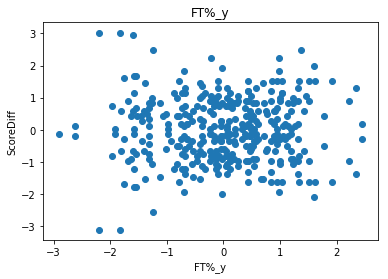

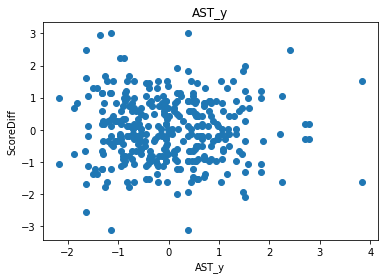

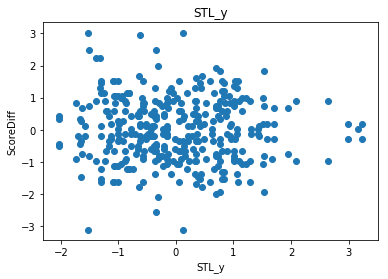

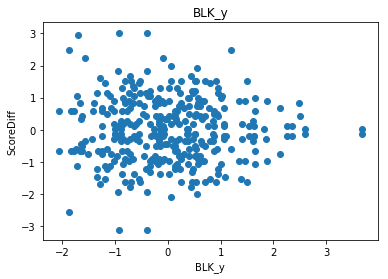

In [35]:
# sns.lmplot(x='W-L%_x', y='ScoreDiff', data=normed_train_data)
for col, series in normed_train_data.iteritems():
    plt.figure()
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('ScoreDiff')

    plt.scatter(series, normed_train_labels)
    

# IV. Build the model.

In [36]:
model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(normed_train_data.keys())]),
    layers.Dense(1)
  ])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                2688      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 2,753
Trainable params: 2,753
Non-trainable params: 0
_________________________________________________________________


In [37]:
optimizer = tf.train.RMSPropOptimizer(0.001)

model.compile(loss='mse',
            optimizer=optimizer,
            metrics=['mae', 'mse'])

example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.29643577],
       [ 0.70307577],
       [-0.30667576],
       [ 0.58101547],
       [-0.24763602],
       [-2.081131  ],
       [-0.27354333],
       [-1.2810428 ],
       [-0.33061773],
       [ 0.21091425]], dtype=float32)

# V. Train the Model

In [38]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

history = model.fit(normed_train_data, normed_train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])


.............................................................

In [39]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
56,1.638381,1.052665,1.638381,0.873144,0.720850,0.873144,56
57,1.604178,1.044401,1.604178,0.867772,0.717072,0.867772,57
58,1.610413,1.046040,1.610413,0.862323,0.715257,0.862323,58
59,1.578062,1.039697,1.578062,0.872551,0.718446,0.872551,59
60,1.681538,1.068040,1.681538,0.859282,0.717718,0.859282,60


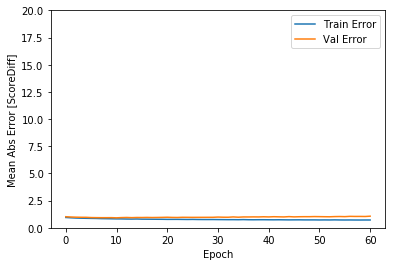

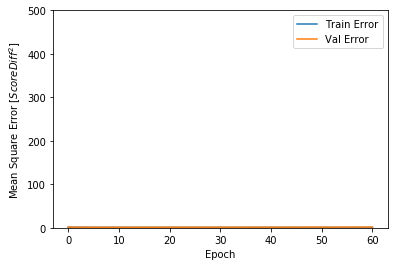

In [40]:
def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [ScoreDiff]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.legend()
  plt.ylim([0,20])
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$ScoreDiff^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.legend()
  plt.ylim([0,500])

plot_history(history)

# VI. Evaluate Model

### Normalize test data

In [41]:
df_final_test_dataset = groom_to_features(test_dataset)
normed_test_data = norm(df_final_test_dataset, train_stats)

normed_test_data.head()

,GameRound,Seed_int_x,Seed_int_y,G_x,W_x,L_x,W-L%_x,SRS_x,SOS_x,Points for_x,...,FG%_y,3P_y,3PA_y,3P%_y,FT_y,FTA_y,FT%_y,AST_y,STL_y,BLK_y
9,0.560215,-0.815217,0.227899,-1.002096,-0.450828,-0.193890,-0.091762,0.628925,0.779622,-0.125530,...,0.435945,-1.884883,-1.945694,-1.033906,0.109977,0.119260,0.038839,-0.940915,-0.227605,-1.194431
25,2.467677,-0.815217,-2.090957,1.624996,1.998759,-1.664928,1.756320,1.052697,0.693011,1.702986,...,2.125962,2.046781,1.225219,2.439017,1.435535,1.388707,0.492555,2.254723,0.918632,1.031405
28,-0.393517,-1.038889,1.155442,1.296609,-0.073968,1.277147,-0.596562,-0.014830,0.950678,0.983976,...,-1.990746,0.547074,0.670516,-0.016585,0.121812,0.182282,-0.131305,-1.450564,-0.754874,0.131066
31,0.560215,-1.038889,-0.699643,-0.016937,-0.073968,0.100317,-0.040426,0.067495,0.158189,-0.336274,...,-0.214061,-0.344643,0.256559,-1.560106,-1.203746,-1.438289,0.549270,-0.555235,-1.167520,0.381160
32,-0.393517,-1.038889,1.155442,-0.016937,-0.073968,0.100317,-0.040426,0.067495,0.158189,-0.336274,...,-1.774077,-0.060915,0.364188,-0.963746,-0.943368,-0.970124,-0.216377,-0.885818,-1.327993,-1.569572


## Make Predictions

In [42]:
test_predictions = model.predict(normed_test_data).flatten()

test_predictions = denorm(test_predictions, train_labels.describe().transpose())
test_predictions.shape

(87,)

## Plot Predictions

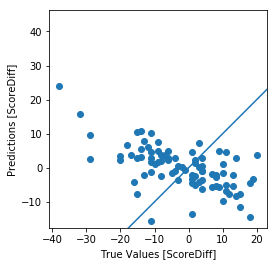

In [43]:
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [ScoreDiff]')
plt.ylabel('Predictions [ScoreDiff]')
plt.axis('equal')
plt.axis('square')

_ = plt.plot([-100, 100], [-100, 100])

In [44]:
test_labels = test_labels.reset_index(drop=True)

df_eval = pd.DataFrame()
df_eval['Predicted'] = test_predictions
df_eval['Actual'] = test_labels

df_eval

,Predicted,Actual
0,2.890497,14
1,10.689357,-14
2,-11.535444,15
3,-3.689160,4
4,2.487542,-29
5,-6.732090,11
6,-13.594089,1
7,-4.404715,18
8,0.291730,-2
9,10.432018,-15


## Evaluate Hit Rate

### Print Hit Rate

In [45]:
correct = 0
incorrect = 0
points_off = 0

def sign(x):
    return 1 - (x<=0)

for i,r in df_eval.iterrows():
    points_off = abs(r['Predicted'] - r['Actual']) + points_off
    if sign(r['Predicted']) == sign(r['Actual']):
        correct = correct + 1
    else:
        incorrect = incorrect + 1
    
total_games = correct+incorrect
hit_rate = correct / total_games
err_per_game = points_off / total_games
print('Total Games: ' + str(total_games))
print('Hit rate: ' + '{:.1%}'.format(hit_rate))
print('Points off per game: ' + str(err_per_game))

Total Games: 87
Hit rate: 25.3%
Points off per game: 13.39087958376983
